In [1]:
import streamlit as st
from PIL import Image
from io import StringIO
import shap
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# local
# API_URL = "http://127.0.0.1:8000/"

# cloud
API_URL = "https://projet-7-modele-de-scoring-6b3669013dac.herokuapp.com/"


# Répertoires
path_dir = "./"


X_train = pd.read_csv(path_dir + 'df_datas_train_reduit_cleaned.csv')
X_test = pd.read_csv(path_dir + 'df_datas_test_reduit_cleaned.csv')


# Valeur du seuil
pourcent_seuil = 45

In [3]:
# Functions
def minmax_scale(df, scaler):
    """Preprocessing du dataframe en paramètre avec le scaler renseigné.
    :param: df, scaler (str).
    :return: df_scaled.
    """
    cols = df.select_dtypes(['float64']).columns
    df_scaled = df.copy()
    if scaler == 'minmax':
        scal = MinMaxScaler()
    else:
        scal = StandardScaler()

    df_scaled[cols] = scal.fit_transform(df[cols])
    return df_scaled


def get_prediction(client_id):
    """Récupère la probabilité de défaut du client via l'API.
    :param: client_id (int).
    :return: probabilité de défaut (float) et la décision (str)
    """
    url_get_pred = API_URL + "prediction/" + str(client_id)
    response = requests.get(url_get_pred)
    proba_default = round(float(response.content), 3)
    best_seuil = pourcent_seuil / 100
    if proba_default >= best_seuil:
        decision = "Refusé"
    else:
        decision = "Accordé"

    return proba_default, decision


def jauge_score(proba):
    """Construit une jauge indiquant le score du client.
    :param: proba (float).
    """
    fig = go.Figure(go.Indicator(
        domain={'x': [0, 1], 'y': [0, 1]},
        value=proba * 100,
        mode="gauge+number+delta",
        title={'text': "Jauge de score"},
        delta={'reference': pourcent_seuil},
        gauge={'axis': {'range': [None, 100], 'tickwidth': 1, 'tickcolor': "black"},
               'bar': {'color': "MidnightBlue"},
               'steps': [
                   {'range': [0, 20], 'color': "Green"},
                   {'range': [20, 45], 'color': "LimeGreen"},
                   {'range': [45, pourcent_seuil], 'color': "Orange"},
                   {'range': [pourcent_seuil, 100], 'color': "Red"}],
               'threshold': {'line': {'color': "brown", 'width': 4}, 'thickness': 1, 'value': pourcent_seuil}}))

    st.plotly_chart(fig)


def get_shap_val_local(client_id):
    """Récupère les shap value du client via l'API pour une interprétation locale.
    :param: client_id (int).
    :return: shap_local
    """
    url_get_shap_local = API_URL + "shaplocal/" + str(client_id)

    response = requests.get(url_get_shap_local)
    res = json.loads(response.content)
    shap_val_local = res['shap_values']
    base_value = res['base_value']
    feat_values = res['data']
    feat_names = res['feature_names']

    explanation = shap.Explanation(np.reshape(np.array(shap_val_local, dtype='float'), (1, -1)),
                                   base_value,
                                   data=np.reshape(np.array(feat_values, dtype='float'), (1, -1)),
                                   feature_names=feat_names)

    return explanation[0]


def get_shap_val():
    """Récupère les shap value globales du jeu de données.
    :param:
    :return: shap_global
    """
    url_get_shap = API_URL + "shap/"
    response = requests.get(url_get_shap)
    content = json.loads(response.content)
    shap_val_glob_0 = content['shap_values_0']
    shap_val_glob_1 = content['shap_values_1']
    shap_globales = np.array([shap_val_glob_0, shap_val_glob_1])

    return shap_globales


def df_voisins(id_client):
    """Récupère les clients similaires à celui dont l'ID est passé en paramètre.
    :param: id_client (int)
    :return: data_voisins
    """
    url_get_df_voisins = API_URL + "clients_similaires/" + str(id_client)
    response = requests.get(url_get_df_voisins)
    data_voisins = pd.read_json(StringIO(eval(response.content)))

    return data_voisins


def distribution(feature, id_client, df):
    """Affiche la distribution de la feature indiquée en paramètre et ce pour les 2 targets.
    Affiche également la position du client dont l'ID est renseigné en paramètre dans ce graphique.
    :param: feature (str), id_client (int), df.
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.hist(df[df['TARGET'] == 0][feature], bins=30, label='accordé')
    ax.hist(df[df['TARGET'] == 1][feature], bins=30, label='refusé')

    observation_value = X_test.loc[X_test['SK_ID_CURR'] == id_client][feature].values
    ax.axvline(observation_value, color='green', linestyle='dashed', linewidth=2, label='Client')

    ax.set_xlabel('Valeur de la feature', fontsize=20)
    ax.set_ylabel('Nombre d\'occurrences', fontsize=20)
    ax.set_title(f'Histogramme de la feature "{feature}" pour les cibles accordé et refusé', fontsize=22)
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    fig.show()


def scatter(id_client, feature_x, feature_y, df):
    """Affiche le nuage de points de la feature_y en fonction de la feature_x.
    Affiche également la position du client dont l'ID est renseigné en paramètre dans ce graphique.
    :param: id_client (int), feature_x (str), feature_y (str), df.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    data_accord = df[df['TARGET'] == 0]
    data_refus = df[df['TARGET'] == 1]
    ax.scatter(data_accord[feature_x], data_accord[feature_y], color='blue',
               alpha=0.5, label='accordé')
    ax.scatter(data_refus[feature_x], data_refus[feature_y], color='red',
               alpha=0.5, label='refusé')

    data_client = X_test.loc[X_test['SK_ID_CURR'] == id_client]
    observation_x = data_client[feature_x]
    observation_y = data_client[feature_y]
    ax.scatter(observation_x, observation_y, marker='*', s=200, color='black', label='Client')

    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.set_title(f'Analyse bivariée des caractéristiques sélectionnées')
    ax.legend()

    fig.show()


def boxplot_graph(id_client, feat, df_vois):
    """Affiche les boxplot des variables renseignéees en paramètre pour chaque target.
    Affiche également la position du client dont l'ID est renseigné en paramètre dans ce graphique.
    Affiche les 10 plus proches voisins du client sur les boxplot.
    :param: id_client (int), feat (str), df_vois.
    """
    df_box = X_train_scaled.melt(id_vars=['TARGET'], value_vars=feat,
                                var_name="variables", value_name="values")
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(data=df_box, x='variables', y='values', hue='TARGET', ax=ax)


    df_voisins_scaled = minmax_scale(df_vois, 'minmax')
    df_voisins_box = df_voisins_scaled.melt(id_vars=['TARGET'], value_vars=feat,
                                            var_name="var", value_name="val")
    sns.swarmplot(data=df_voisins_box, x='var', y='val', hue='TARGET', size=8,
                  palette=['green', 'red'], ax=ax)

    data_client = X_test_scaled.loc[X_test_scaled['SK_ID_CURR'] == id_client][feat].reset_index()
    categories = ax.get_xticks()
    for cat in categories:
        plt.scatter(cat, data_client.iloc[:, cat], marker='*', s=250, color='blueviolet', label='Client')

    ax.set_title(f'Boxplot des caractéristiques sélectionnées')
    handles, _ = ax.get_legend_handles_labels()
    if len(handles) < 8:
        ax.legend(handles[:4], ['Accordé', 'Refusé', 'Voisins', 'Client'])
    else:
        ax.legend(handles[:5], ['Accordé', 'Refusé', 'Voisins (accordés)', 'Voisins (refusés)', 'Client'])

    fig.show()

In [4]:
X_train.head()

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,...,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
0,391369,0.385400,0.367291,66.594521,0.777778,0.333333,778.0,1648.0,3,0.111111,...,48600.0,76410.0,5233.5,67500.0,6.0,2.0,7.0,58.0,0,0
1,131710,0.608885,0.501075,28.057534,0.000000,0.777778,1397.0,1767.0,2,0.000000,...,180000.0,341280.0,24961.5,270000.0,2.0,2.0,13.0,43.0,0,1
2,248985,0.025221,0.497469,59.336986,0.000000,0.750000,1431.0,1648.0,2,0.000000,...,67500.0,112500.0,11947.5,112500.0,2.0,2.0,7.0,58.0,0,0
3,291263,0.659627,0.294083,22.635616,0.000000,0.000000,67.0,171.0,2,0.000000,...,184500.0,204768.0,14967.0,162000.0,1.0,6.0,7.0,6.0,1,0
4,233182,0.466877,0.716570,45.991781,0.000000,0.375000,2294.0,6760.0,3,0.000000,...,247500.0,1237500.0,36184.5,1237500.0,2.0,2.0,7.0,42.0,1,0


In [5]:
X_test.head()

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,...,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
0,186426,0.317328,0.181959,25.871233,0.00,0.727273,668.0,2399.0,2,0.000000,...,225000.0,270000.0,21460.5,270000.0,4.0,6.0,14.0,5.0,0,1
1,239207,0.709575,0.244516,60.460274,0.00,0.250000,802.0,1765.0,2,0.000000,...,67500.0,144801.0,10953.0,117000.0,4.0,2.0,7.0,58.0,0,0
2,243371,0.672684,0.340906,34.920548,0.00,0.750000,1457.0,1577.0,1,0.000000,...,270000.0,846000.0,54198.0,846000.0,2.0,2.0,7.0,8.0,0,0
3,156405,0.748743,0.438281,27.561644,0.00,0.500000,1423.0,1730.0,3,0.000000,...,225000.0,334152.0,17190.0,270000.0,4.0,2.0,14.0,52.0,0,0
4,412720,0.687765,0.241861,42.857534,0.25,0.571429,2821.0,791.0,2,0.166667,...,234000.0,675000.0,49117.5,675000.0,2.0,2.0,7.0,56.0,0,0


In [6]:
X_train_scaled = minmax_scale(X_train, 'minmax')
X_test_scaled = minmax_scale(X_test, 'minmax')

In [7]:
id_client_dash = 239207
probability, decision = get_prediction(id_client_dash)
print(probability, decision)

0.407 Accordé


In [8]:
id_client_dash = 412720
probability, decision = get_prediction(id_client_dash)
print(probability, decision)

0.542 Refusé


In [9]:
jauge_score(probability)

2026-01-02 18:47:05.622 
  command:

    streamlit run C:\Users\jme1401\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [10]:
fig = go.Figure(go.Indicator(
        domain={'x': [0, 1], 'y': [0, 1]},
        value=probability * 100,
        mode="gauge+number+delta",
        title={'text': "Jauge de score"},
        delta={'reference': pourcent_seuil},
        gauge={'axis': {'range': [None, 100], 'tickwidth': 1, 'tickcolor': "black"},
               'bar': {'color': "MidnightBlue"},
               'steps': [
                   {'range': [0, 20], 'color': "Green"},
                   {'range': [20, 45], 'color': "LimeGreen"},
                   {'range': [45, pourcent_seuil], 'color': "Orange"},
                   {'range': [pourcent_seuil, 100], 'color': "Red"}],
               'threshold': {'line': {'color': "brown", 'width': 4}, 'thickness': 1, 'value': pourcent_seuil}}))
fig

In [11]:
pd.DataFrame(X_test.loc[X_test['SK_ID_CURR'] == id_client_dash])

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,...,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
4,412720,0.687765,0.241861,42.857534,0.25,0.571429,2821.0,791.0,2,0.166667,...,234000.0,675000.0,49117.5,675000.0,2.0,2.0,7.0,56.0,0,0


In [12]:
id_client_dash = 239207
shap_val = get_shap_val_local(id_client_dash)
nb_features = 5
fig = shap.waterfall_plot(shap_val, max_display=nb_features, show=True)

C:\Users\jme1401\AppData\Roaming\Python\Python312\site-packages\shap\plots\_waterfall.py:368: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [13]:
get_shap_val()

array([[ 0.32222147,  0.71256608, -0.39321664, -0.05303991, -0.09427491,
         0.01865461, -0.02992634,  0.00261411, -0.01116268, -0.01336895,
        -0.19066352, -0.0027416 ,  0.05239172, -0.08383528, -0.01090637,
        -0.03940849,  0.03788354, -0.01112274,  0.10445921, -0.05914336,
        -0.01593932,  0.00374201, -0.0247961 ,  0.50139306, -0.14131394,
        -0.0205817 , -0.26431908,  0.1481631 ,  0.03762002,  0.02467332,
        -0.05077628, -0.17721029,  0.14243784,  0.        ,  0.06907967,
         0.04676358,  0.04686308, -0.0243365 , -0.02142605,  0.00371752,
        -0.14352843],
       [-0.5542823 ,  0.61153215, -0.04746431, -0.04663174,  0.07259772,
         0.01276125, -0.02377654,  0.09636955, -0.00985988, -0.00755364,
        -0.14004813,  0.00211002,  0.00477942,  0.00660419,  0.01507848,
        -0.02868901, -0.06348218, -0.01626707,  0.00940761, -0.03515532,
        -0.00532007,  0.00464562,  0.00620821,  0.11808419, -0.1183053 ,
        -0.01990029, -0.22000

In [14]:
id_client_dash = 239207
data_voisins = df_voisins(id_client_dash)
data_voisins.head(20)

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,...,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
24955,258825,0.743070,0.315472,67.813699,0.000,0.250000,1276,1648,3,0,...,135000,239850,23494.5,225000,6,2,7,58,0,0
19606,222103,0.623237,0.309275,61.665753,0.000,0.571429,1154,1648,2,0,...,103500,225000,11250.0,225000,4,2,7,58,0,0
28857,446242,0.589573,0.572683,60.786301,0.000,0.333333,480,1648,3,0,...,85500,153000,7569.0,153000,3,2,7,58,0,0
9475,163668,0.660206,0.497469,64.772603,0.000,0.500000,1599,1648,2,0,...,90000,227493,17136.0,207000,2,2,7,58,0,0
14917,450368,0.670702,0.420611,60.556164,0.000,0.000000,295,1648,2,0,...,63000,207306,9261.0,148500,2,2,9,58,0,0
17278,264166,0.749861,0.329655,59.580822,0.000,0.000000,141,1648,2,0,...,121500,454500,18022.5,454500,6,2,7,58,0,0
19149,134420,0.603807,0.190706,61.715068,0.125,0.500000,1036,1648,2,0,...,112500,360000,18000.0,360000,2,2,7,58,0,0
10196,354741,0.335347,0.282248,61.243836,0.000,0.250000,697,1648,2,0,...,72000,202500,10125.0,202500,6,2,7,58,0,0
3887,178765,0.707810,0.535276,62.594521,0.000,0.166667,1519,1648,2,0,...,135000,213156,7654.5,139500,4,2,7,58,1,0
12499,177110,0.720354,0.457900,68.153425,0.200,0.250000,974,1648,2,0,...,157500,158301,15552.0,148500,6,2,7,58,0,0


In [15]:
id_client_dash = 239207
distribution("DAYS_BIRTH", id_client_dash, X_train)

C:\Users\jme1401\AppData\Local\Temp\ipykernel_55276\3000539528.py:124: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [16]:
id_client_dash = 192535
scatter(id_client_dash, "DAYS_BIRTH", "AMT_CREDIT", X_train)

C:\Users\jme1401\AppData\Local\Temp\ipykernel_55276\3000539528.py:151: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [17]:
id_client_dash = 239207
boxplot_graph(id_client_dash, "DAYS_BIRTH", data_voisins)

C:\Users\jme1401\AppData\Local\Temp\ipykernel_55276\3000539528.py:169: UserWarning:

The palette list has more values (2) than needed (1), which may not be intended.

C:\Users\jme1401\AppData\Local\Temp\ipykernel_55276\3000539528.py:184: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



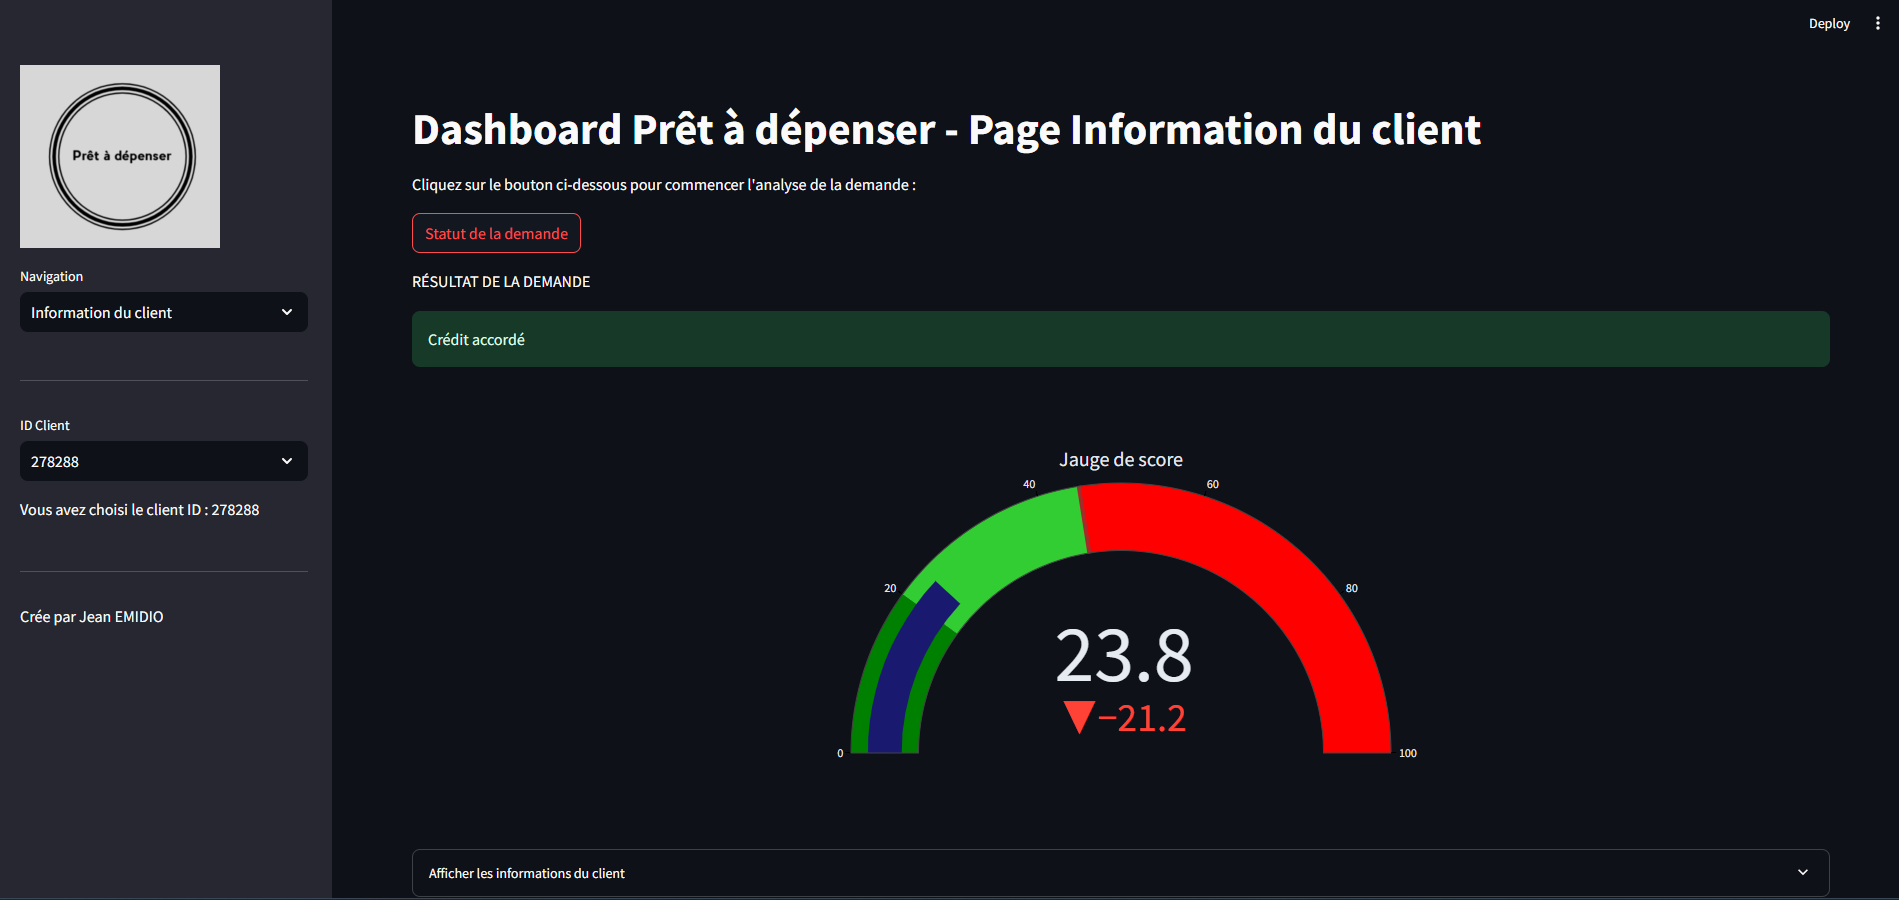

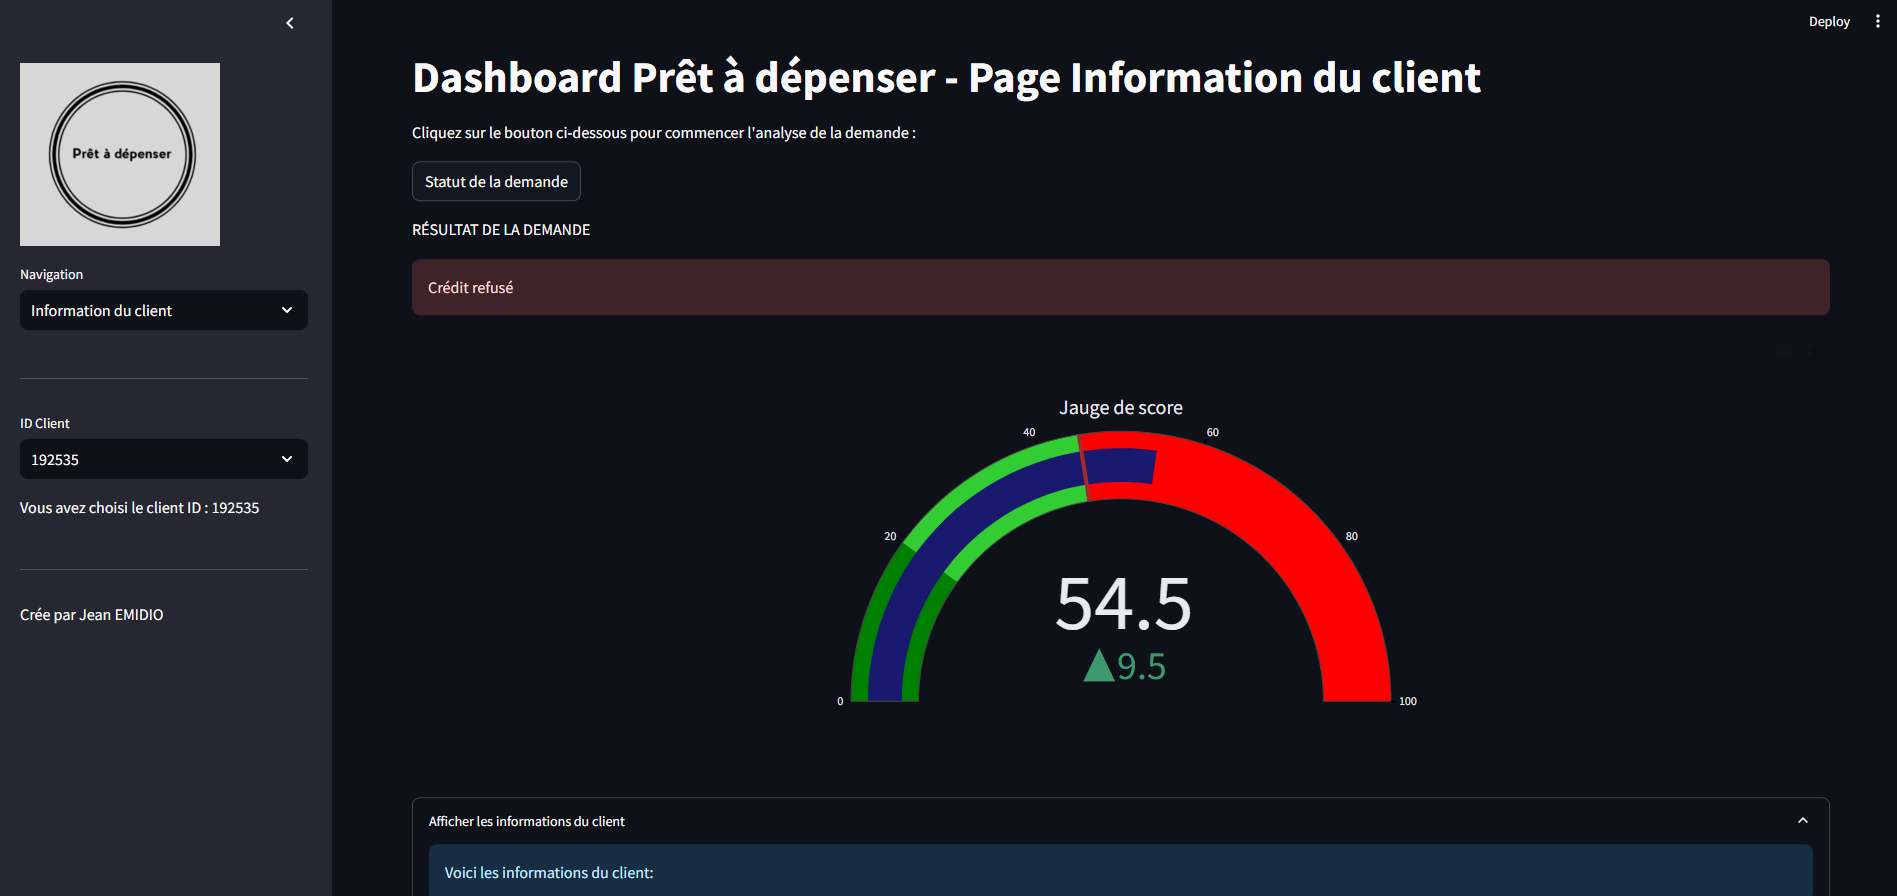